In [1]:
import sys
sys.path.append("../scripts/python")
sys.path.append("../algotom")
import amglib.imageutils as utils
import amglib.readers as io
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import skimage as im
import scipy.io
import os
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

import importlib

C:\Users\zhan_q\Documents\CIL\../scripts/python\amglib\imageutils.py:8: FutureWarning: Importing from skimage.morphology.greyreconstruct is deprecated. Please import from skimage.morphology instead.
  import skimage.morphology.greyreconstruct as rec


In [2]:
datapath = 'E:\\Zhan_q\\P20220873\\02_rawdata2\\01_ct05s\\'

In [15]:
dc=io.read_images(datapath+'dc05s_{:05}.fits',first=1,last=10,averageStack=True,average='mean');
ob=io.read_images(datapath+'ob05s_{:05}.fits',first=1,last=10,averageStack=True,average='mean');
bbob1 = io.read_image(datapath+'bbob05s_00001.fits');
bb1 = io.read_image(datapath+'bbs05s_00001.fits');
bb2 = io.read_image(datapath+'bbs05s_00002.fits');

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
bb3 = io.read_image(datapath+'bbs05s_00003.fits');
bb4 = io.read_image(datapath+'bbs05s_00004.fits');

In [4]:
bbs = io.read_images(datapath+'bbs05s_{:05}.fits', first=1, last=5, averageStack=True, average='mean');
bbob = io.read_images(datapath+'bbob05s_{:05}.fits', first=1, last=5, averageStack=True, average='mean');

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

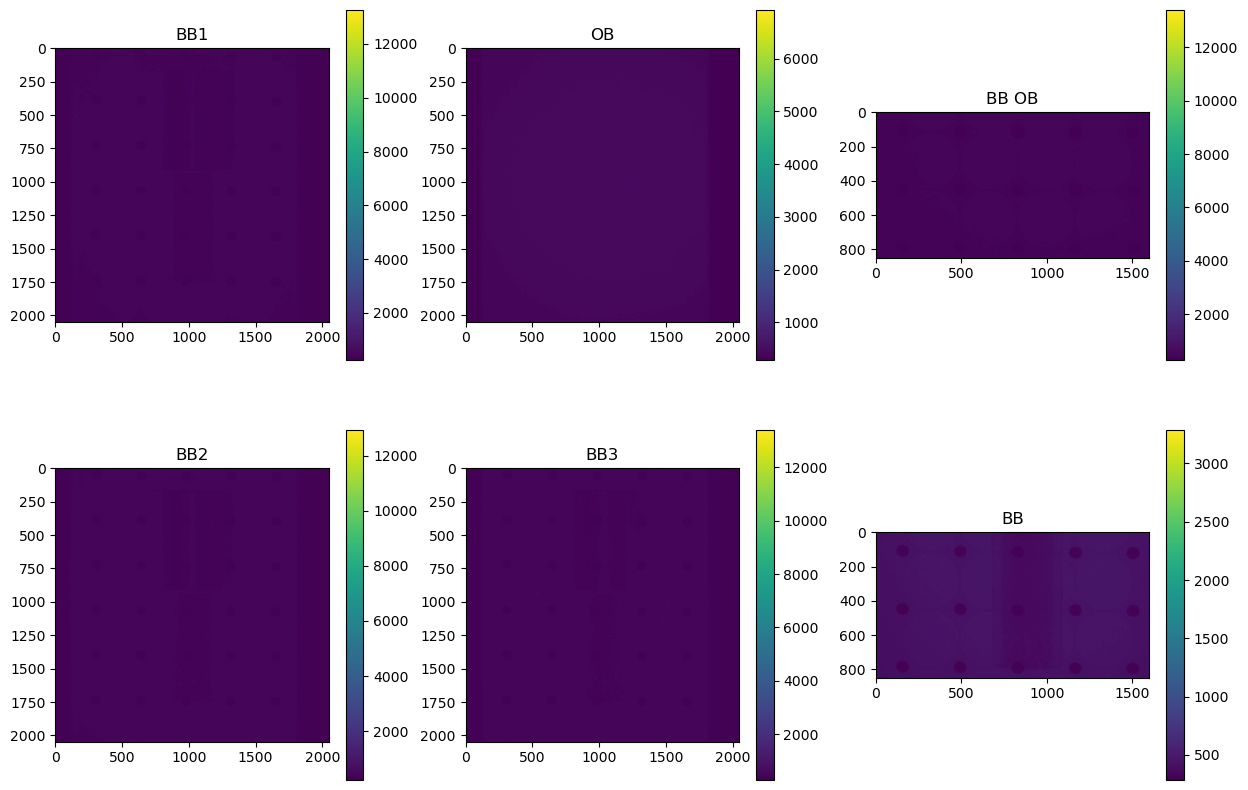

In [18]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
ax=ax.ravel()

a0 = ax[0].imshow(bb1)
fig.colorbar(a0, ax=ax[0])
ax[0].set_title('BB1')

a1=ax[1].imshow(ob)#, vmin=0.0,vmax=10000)
fig.colorbar(a1,ax=ax[1])
ax[1].set_title('OB')

a2=ax[2].imshow(bbob)
fig.colorbar(a2,ax=ax[2])
ax[2].set_title('BB OB');

a3 = ax[3].imshow(bb2)
fig.colorbar(a3, ax=ax[3])
ax[3].set_title('BB2');

a4=ax[4].imshow(bb3)
fig.colorbar(a2,ax=ax[4])
ax[4].set_title('BB3');

a5 = ax[5].imshow(bbs)
fig.colorbar(a5, ax=ax[5])
ax[5].set_title('BB');

In [23]:
dc = dc[950:1800,150:1750]
ob = ob[950:1800,150:1750]
bbob = bbob[950:1800,150:1750]
bbs = bbs[950:1800,150:1750]

NameError: name 'ImgRaw' is not defined

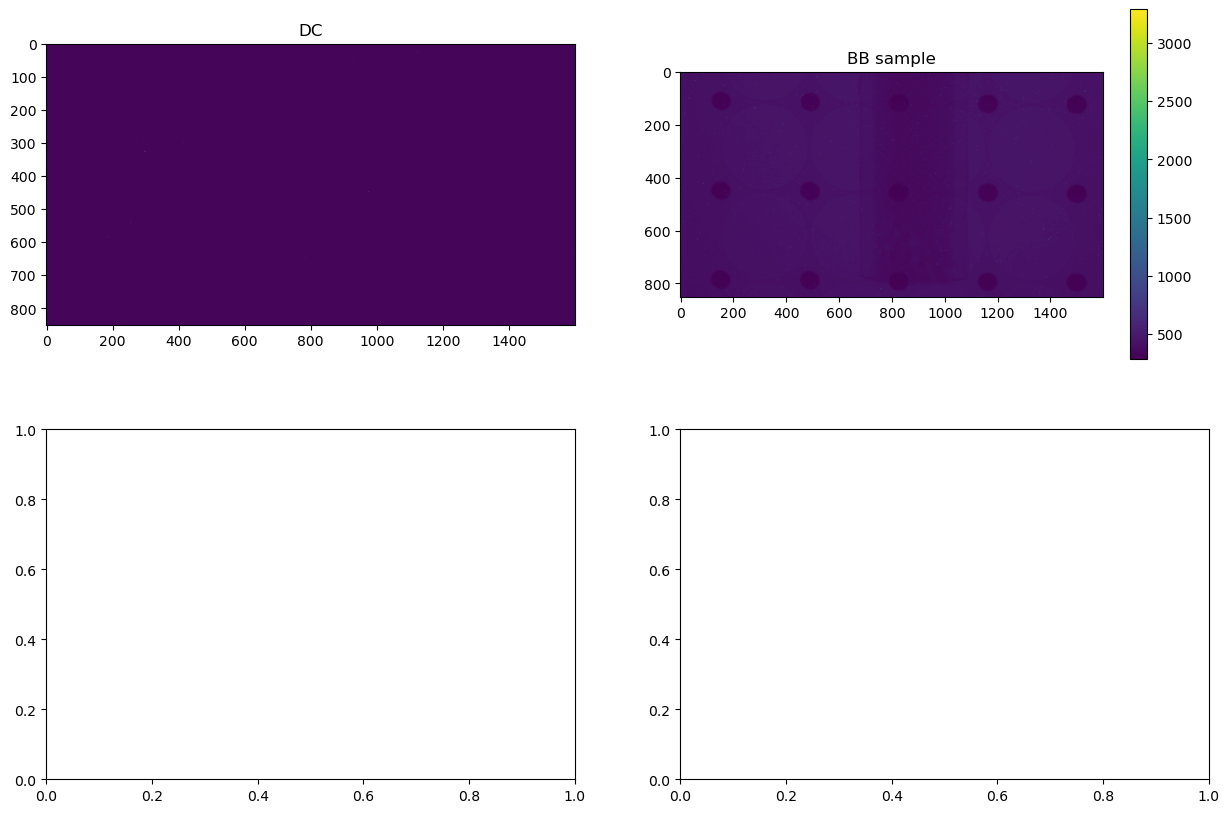

In [6]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
ax=ax.ravel()
ax[0].imshow(dc)
ax[0].set_title('DC')
a1=ax[1].imshow(bbs)
fig.colorbar(a1,ax=ax[1])
ax[1].set_title('BB sample')
a2=ax[2].imshow(ImgRaw[300,:,:]) #,vmin=0.0,vmax=10000)
fig.colorbar(a2,ax=ax[2])
ax[2].set_title('Projection');
a3=ax[3].imshow(bbs[600:650,300:350]) #,vmin=0.0,vmax=10000)
fig.colorbar(a3,ax=ax[3])
ax[3].set_title('does ROI');

### BB correction

In [7]:
import amglib.readers as rd
import amglib.bb as bb
from skimage.measure import label, regionprops
import pandas as pd
import skimage.morphology as morph
import skimage.filters as filt
from skimage.feature import match_template
from skimage.draw import disk

In [8]:
import importlib
importlib.reload(rd)
importlib.reload(bb)

<module 'amglib.bb' from 'C:\\Users\\zhan_q\\Documents\\CIL\\../scripts/python\\amglib\\bb.py'>

In [9]:
proj = io.read_image(datapath+'ct05s_00001.fits')

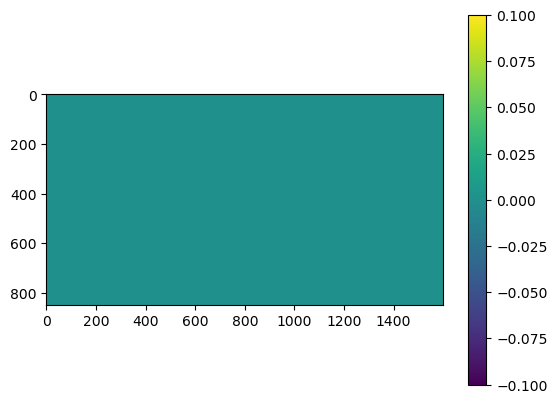

In [19]:
#plt.imshow(bbob<2100)
plt.imshow(label(bbob<100))
plt.colorbar()
lbb=label(label(bbob<100))
props = regionprops(lbb)
for region in props:
    print(region.area)

In [20]:
ImgRaw = io.read_images(datapath+'ct05s_{:05}.fits',first=1,last = 1126,stride=1); 

  0%|          | 0/1126 [00:00<?, ?it/s]

In [21]:
ImgRaw = ImgRaw[:,950:1800,150:1750]

In [162]:
ImgNorm = bb.normalization_with_BB(ImgRaw,ob,dc,bbs,bbob,ss,sob,[600,300,650,350],0.97).astype('float32');
#utils.normalizeImage(ImgRaw, ob, dc, neglog = True, doseROI = [150,100,200,150]).astype('float32');

In [164]:
ImgNorm=-np.log(ImgNorm).astype('float32');

C:\Users\zhan_q\AppData\Local\Temp\ipykernel_11008\2492741168.py:1: RuntimeWarning: invalid value encountered in log
  ImgNorm=-np.log(ImgNorm).astype('float32');


In [24]:
ImgNorm_dose = bb.normalize(ImgRaw,ob,dc, dose_roi = [600,300,650,350], logarithm=True).astype('float32');

In [25]:
print(ImgNorm_dose.shape)

(1126, 850, 1600)


In [26]:
# Import all CIL components needed
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData

# CIL Processors
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter, Normaliser, Padder

# CIL display tools
from cil.utilities.display import show2D, show_geometry

# From CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator, FBP

from cil.processors import RingRemover, Binner
from cil.utilities.jupyter import islicer, link_islicer
from cil.processors import Masker, MaskGenerator

import logging
logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.INFO)

In [27]:
agRaw = AcquisitionGeometry.create_Parallel3D()  \
         .set_panel(num_pixels=(1600, 850))        \
         .set_angles(angles=np.linspace(0, 360, num=1126, endpoint=False))

In [28]:
print(agRaw)

3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [0., 0., 0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1600  850]
	Pixel size: [1. 1.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1126
	Angles 0-20 in degrees:
[0.        , 0.3197158 , 0.6394316 , 0.95914745, 1.2788632 , 1.598579  ,
 1.9182949 , 2.2380106 , 2.5577264 , 2.8774424 , 3.197158  , 3.5168738 ,
 3.8365898 , 4.1563053 , 4.4760213 , 4.7957373 , 5.115453  , 5.4351687 ,
 5.7548847 , 6.0746    ]



In [29]:
agRaw.set_labels(['angle','vertical','horizontal'])
print(agRaw.dimension_labels)

('angle', 'vertical', 'horizontal')


In [30]:
data3D = AcquisitionData(ImgNorm_dose, geometry=agRaw, deep_copy=False)

In [31]:
islicer(data3D, cmap='inferno', 
        minmax=(0,1.2), 
        size=(7,7))

interactive(children=(IntSlider(value=563, continuous_update=False, description='angle', max=1125), FloatRange…

IntSlider(value=563, continuous_update=False, description='angle', max=1125)

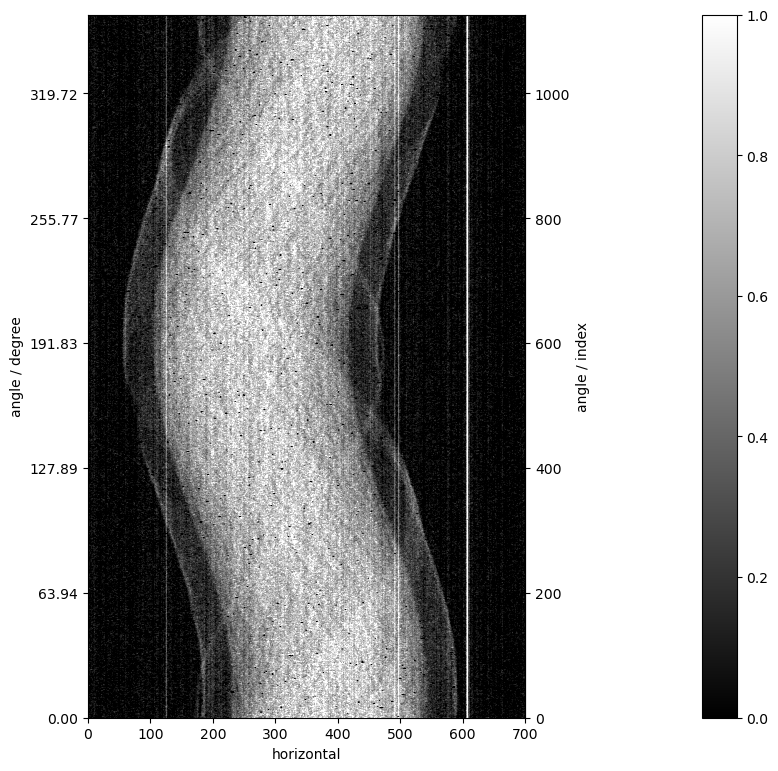

In [33]:
nv = 100
data3D_roi = Slicer(roi={'horizontal':(500,1200)})(data3D)
data2D = data3D_roi.get_slice(vertical=nv)
show2D(data2D,\
      fix_range=(0,1.0),
      cmap='gray')

In [34]:
test_01_ct05s = Slicer(roi={'horizontal':(500,1200)})(data3D)
%store test_01_ct05s

Stored 'test_01_ct05s' (AcquisitionData)
